# Funzioni

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics
from sklearn.model_selection import cross_val_score, train_test_split

In [2]:
from sklearn.metrics import ConfusionMatrixDisplay

def fit_predict_print(train, test, target_columns, estimator):
  X_tr = train.drop(columns=target_columns)
  y_tr = train[target_columns]
  X_ts = test.drop(columns=target_columns)
  y_ts = test[target_columns]

  return fit_predict_print_1(X_tr, X_ts, y_tr, y_ts, estimator)


def fit_predict_print_1(X_train, X_test, y_train, y_test, estimator):
  y_pred = estimator.fit(X_train, y_train).predict(X_test)

  print('Accuracy:', metrics.accuracy_score(y_test, y_pred))
  cm = metrics.confusion_matrix(y_test, y_pred)
  print('Confusion matrix:\n', cm)
  cmn = metrics.confusion_matrix(y_test, y_pred, normalize='true')
  ConfusionMatrixDisplay(cmn, display_labels=estimator.classes_).plot()
  return y_pred

In [3]:
def balanced_subsample(X, y, subsample_size=1.0):

    classes = y.unique()
    min_elems = y.value_counts().min()

    use_elems = min_elems
    if subsample_size < 1:
        use_elems = int(min_elems * subsample_size)

    Xb = pd.DataFrame()
    yb = pd.Series()

    for c in classes:
      X_ = X[y == c]
      if X_.shape[0] > use_elems:
        X_ = X_.sample(use_elems)

      yc = np.empty(use_elems)
      yc.fill(c)
      y_ = pd.Series(yc)

      Xb = pd.concat([Xb, X_])
      yb = pd.concat([yb, y_])

    return Xb, yb

In [4]:
from sklearn.preprocessing import OneHotEncoder

def one_hot_encode(dataset, columns, drop=None):

  categories = []
  ret_columns = []

  if isinstance(columns, str):
    columns = [columns]
  if (drop is not None) and (isinstance(drop, str)):
    drop = [drop]

  for i in range(0, len(columns)):
    ctg = dataset.loc[:, columns[i]].unique().tolist()
    categories.append(ctg)

    ctg_ = ctg.copy();
    if drop is not None:
      ctg_.remove(drop[i])
    ret_columns += ctg_

  encoder = OneHotEncoder(categories=categories, drop=drop).fit(dataset[columns])
  ds = pd.DataFrame(encoder.transform(dataset[columns]).toarray(), columns=ret_columns)

  return ds


def add_dummies(dataset, columns, drop_cat=None, drop_col=True):
  dummies = one_hot_encode(dataset, columns, drop_cat)
  if drop_col:
    ret = pd.concat([dataset.drop(columns=columns), dummies], axis=1)
  else:
    ret = pd.concat([dataset, dummies], axis=1)
  return ret

In [5]:
def xtab(rows_data, cols_data, normalize_rows=False):
  xtab = pd.crosstab(rows_data, cols_data)
  if normalize_rows:
    for i in xtab.index:
      xtab.loc[i] = xtab.loc[i] / (rows_data == i).sum()
    _ = sns.heatmap(xtab, vmin=0, vmax=1)
  else:
    _ = sns.heatmap(xtab)
  print(xtab)
  return xtab

# Parte 1: Analisi

### 1

In [6]:
dataset = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/BDA/data/heart_failure_clinical_records_dataset.csv')

In [7]:
dataset.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


In [8]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    int64  
 2   creatinine_phosphokinase  299 non-null    int64  
 3   diabetes                  299 non-null    int64  
 4   ejection_fraction         299 non-null    int64  
 5   high_blood_pressure       299 non-null    int64  
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    int64  
 9   sex                       299 non-null    int64  
 10  smoking                   299 non-null    int64  
 11  time                      299 non-null    int64  
 12  DEATH_EVENT               299 non-null    int64  
dtypes: float64(3), int64(10)
memory usage: 30.5 KB


In [9]:
dataset.DEATH_EVENT.value_counts()

0    203
1     96
Name: DEATH_EVENT, dtype: int64

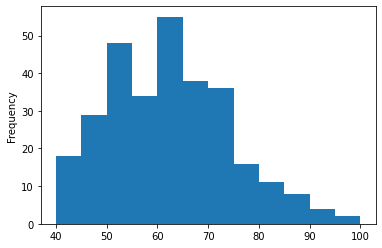

In [12]:
dataset.age.plot(kind='hist', bins=range(40, 101, 5))

### 2

DEATH_EVENT         0         1
sex                            
0            0.676190  0.323810
1            0.680412  0.319588


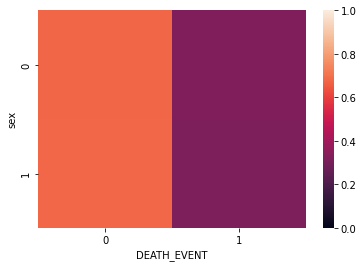

In [16]:
_ = xtab(dataset.sex, dataset.DEATH_EVENT, normalize_rows=True)

### 3

In [19]:
dataset['age_bins'] = pd.cut(dataset.age, 5)

pd.pivot_table(dataset, values='DEATH_EVENT', index='age_bins', 
               columns=['sex', 'smoking'])

sex                    0              1          
smoking                0    1         0         1
age_bins                                         
(39.945, 51.0]  0.258065  1.0  0.346154  0.100000
(51.0, 62.0]    0.333333  1.0  0.218750  0.250000
(62.0, 73.0]    0.250000  0.5  0.260870  0.357143
(73.0, 84.0]    0.750000  NaN  0.571429  0.444444
(84.0, 95.0]    0.500000  NaN  0.714286  1.000000

### 4

diabetes   0   1
anaemia         
0         98  72
1         76  53


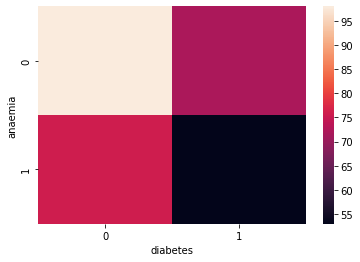

In [20]:
_ = xtab(dataset.anaemia, dataset.diabetes)

### 5

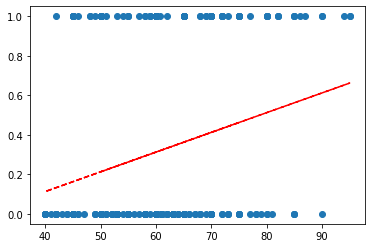

In [41]:
# ds = dataset.groupby('age').mean()['DEATH_EVENT']
#x = ds.index
# y = ds

x = dataset.age
y = dataset.DEATH_EVENT

_ = plt.scatter(x, y)

z = np.polyfit(x, y, 1)
p = np.poly1d(z)
_ = plt.plot(x, p(x), "r--")

DEATH_EVENT         0         1
age_bins                       
(40, 45]     0.766667  0.233333
(45, 50]     0.675676  0.324324
(50, 55]     0.842105  0.157895
(55, 60]     0.620000  0.380000
(60, 65]     0.791667  0.208333
(65, 70]     0.702703  0.297297
(70, 75]     0.454545  0.545455
(75, 80]     0.500000  0.500000
(80, 85]     0.400000  0.600000
(85, 90]     0.200000  0.800000
(90, 95]     0.000000  1.000000


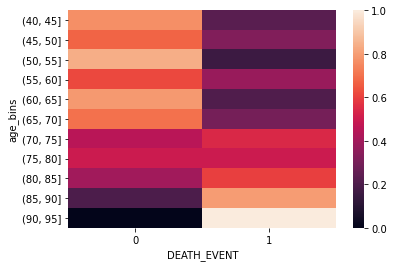

In [43]:
dataset['age_bins'] = pd.cut(dataset.age, bins=range(40, 101, 5))

_ = xtab(dataset.age_bins, dataset.DEATH_EVENT, normalize_rows=True)

# Parte 2: Trasformazione e Predizione

### 1

In [50]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier

In [54]:
dataset.drop(columns='age_bins', inplace=True)

In [55]:
X = dataset.drop(columns='DEATH_EVENT')
y = dataset.DEATH_EVENT

In [56]:
X_tr, X_ts, y_tr, y_ts = train_test_split(X, y, train_size=2/3, random_state=1)

Accuracy: 1.0
Confusion matrix:
 [[132   0]
 [  0  67]]


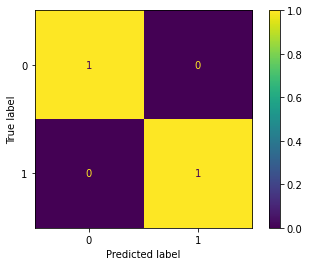

In [57]:
_ = fit_predict_print_1(X_tr, X_tr, y_tr, y_tr, DecisionTreeClassifier())

Accuracy: 0.76
Confusion matrix:
 [[61 10]
 [14 15]]


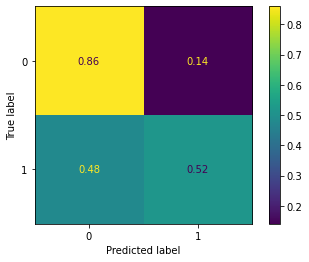

In [58]:
_ = fit_predict_print_1(X_tr, X_ts, y_tr, y_ts, DecisionTreeClassifier())

Accuracy: 0.8291457286432161
Confusion matrix:
 [[119  13]
 [ 21  46]]


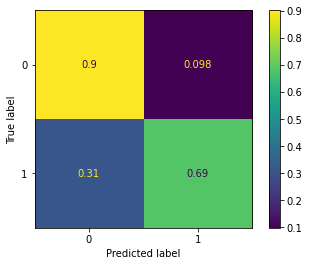

In [59]:
_ = fit_predict_print_1(X_tr, X_tr, y_tr, y_tr, LogisticRegression(n_jobs=-1))

Accuracy: 0.8
Confusion matrix:
 [[62  9]
 [11 18]]


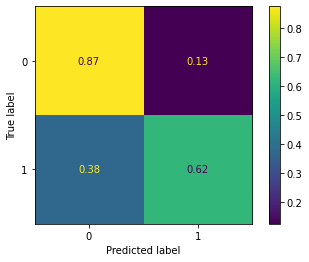

In [60]:
_ = fit_predict_print_1(X_tr, X_ts, y_tr, y_ts, LogisticRegression(n_jobs=-1))

Accuracy: 0.6633165829145728
Confusion matrix:
 [[132   0]
 [ 67   0]]


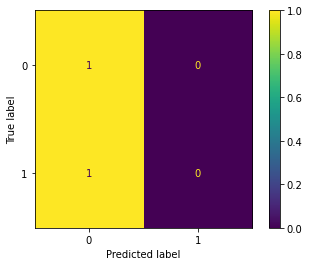

In [63]:
_ = fit_predict_print_1(X_tr, X_tr, y_tr, y_tr, DummyClassifier())

Accuracy: 0.71
Confusion matrix:
 [[71  0]
 [29  0]]


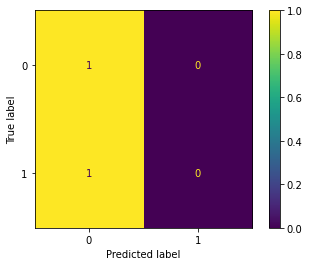

In [61]:
_ = fit_predict_print_1(X_tr, X_ts, y_tr, y_ts, DummyClassifier())

### 2

In [65]:
acc_dt = cross_val_score(DecisionTreeClassifier(), X, y, scoring='accuracy',
                         cv=5, n_jobs=-1).mean()
acc_lr = cross_val_score(LogisticRegression(), X, y, scoring='accuracy',
                         cv=5, n_jobs=-1).mean()
acc_dc = cross_val_score(DummyClassifier(), X, y, scoring='accuracy',
                         cv=5, n_jobs=-1).mean()

In [67]:
print('Decision Tree:', acc_dt)
print('Logistic Regression:', acc_lr)
print('Dummy Classifier:', acc_dc)

Decision Tree: 0.6254802259887006
Logistic Regression: 0.7789265536723164
Dummy Classifier: 0.6789265536723164


### 3

In [72]:
from sklearn.preprocessing import MaxAbsScaler
from sklearn.linear_model import LinearRegression

In [71]:
dataset1 = dataset.drop(columns='time')

X = dataset1.drop(columns='DEATH_EVENT')
y = dataset1.DEATH_EVENT

X_scaled = MaxAbsScaler().fit_transform(X)

In [104]:
model = LinearRegression(n_jobs=-1).fit(X_scaled, y)

In [105]:
abs_coef = pd.Series(model.coef_).abs().sort_values()
abs_coef

10    0.013404
3     0.016636
1     0.054879
6     0.061292
9     0.062559
5     0.067954
2     0.383628
4     0.847287
0     0.856166
7     0.999425
8     1.622146
dtype: float64

In [106]:
biggest_coef = abs_coef[-5:].index.tolist()
biggest_coef

[2, 4, 0, 7, 8]

In [107]:
X = dataset1.iloc[:, biggest_coef]

In [108]:
X.head()

,creatinine_phosphokinase,ejection_fraction,age,serum_creatinine,serum_sodium
0,582,20,75.0,1.9,130
1,7861,38,55.0,1.1,136
2,146,20,65.0,1.3,129
3,111,20,50.0,1.9,137
4,160,20,65.0,2.7,116


In [109]:
cross_val_score(DecisionTreeClassifier(), X_scaled, y, scoring='accuracy', 
                cv=5, n_jobs=-1).mean()

0.6922033898305084

### 4

In [133]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import KBinsDiscretizer, Normalizer
from sklearn.pipeline import Pipeline

In [160]:
dataset1 = dataset.drop(columns='time')

X = dataset1.drop(columns='DEATH_EVENT')
y = dataset1.DEATH_EVENT

In [168]:
X_tr, X_ts, y_tr, y_ts = train_test_split(X, y, train_size=2/3, random_state=1)

In [161]:
booleans = []
for c in X.columns:
  if (dataset[c].min() == 0) & (dataset1[c].max() == 1) & (
      dataset[c].value_counts().size == 2):
    booleans.append(c)
booleans

['anaemia', 'diabetes', 'high_blood_pressure', 'sex', 'smoking']

In [135]:
to_discr = ['age', 'platelets']

In [162]:
non_bool = X.columns.drop(booleans + to_discr).tolist()
non_bool

['creatinine_phosphokinase',
 'ejection_fraction',
 'serum_creatinine',
 'serum_sodium']

In [164]:
columns = X.columns
to_discr_idx = [ columns.get_loc(k) for k in to_discr ]
non_bool_idx = [ columns.get_loc(k) for k in non_bool ]

In [165]:
non_bool_ppl = Pipeline([
    ('scaler', MaxAbsScaler()),
    ('normal', Normalizer())
])

In [182]:
ct = ColumnTransformer([
    ('non_bool', non_bool_ppl, non_bool_idx),
    ('to_discr', KBinsDiscretizer(6), to_discr_idx),
], remainder='passthrough')

In [183]:
pipeline = Pipeline([
    ('preprocessing', ct),
    ('model', DecisionTreeClassifier())
])

Accuracy: 0.68
Confusion matrix:
 [[53 18]
 [14 15]]


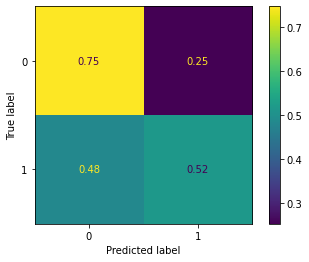

In [184]:
_ = fit_predict_print_1(X_tr, X_ts, y_tr, y_ts, pipeline)

### 5

In [185]:
from sklearn.model_selection import GridSearchCV

In [186]:
param_grid = {
    'preprocessing__to_discr__n_bins': [5, 6, 10, 20],
    'preprocessing__to_discr__strategy': ['quantile', 'uniform'],
    'preprocessing__non_bool__normal__norm': ['l1', 'l2'],
    'model__criterion': ['gini', 'entropy'],
    'model__min_samples_split': [2, 3, 4, 5]
}

In [187]:
gs = GridSearchCV(pipeline, param_grid, scoring='accuracy', n_jobs=-1).fit(X, y)

In [188]:
gs.best_params_

{'model__criterion': 'gini',
 'model__min_samples_split': 5,
 'preprocessing__non_bool__normal__norm': 'l1',
 'preprocessing__to_discr__n_bins': 10,
 'preprocessing__to_discr__strategy': 'quantile'}

In [189]:
gs.best_score_

0.6959887005649718

### 6

In [190]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.decomposition import PCA
from sklearn.preprocessing import FunctionTransformer
from sklearn.feature_selection import SelectKBest

In [191]:
def return_this(arg):
  return arg

fu = FeatureUnion([
    ('pca', PCA(2)),
    ('select_k_best', SelectKBest(k=2)),
    ('passthrough', FunctionTransformer(return_this, validate=False))
])

In [192]:
pipeline = Pipeline([
    ('fu', fu),
    ('preprocessing', ct),
    ('model', DecisionTreeClassifier())
])

In [193]:
dataset1 = dataset.drop(columns='time')

X = dataset1.drop(columns='DEATH_EVENT')
y = dataset1.DEATH_EVENT

In [194]:
X_tr, X_ts, y_tr, y_ts = train_test_split(X, y, train_size=2/3, random_state=1)

Accuracy: 0.72
Confusion matrix:
 [[60 11]
 [17 12]]


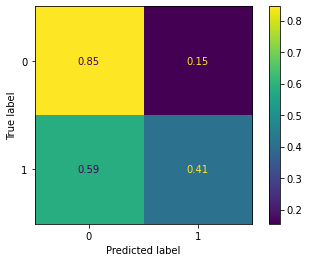

In [195]:
_ = fit_predict_print_1(X_tr, X_ts, y_tr, y_ts, pipeline)